# Credit Card Customer Segmentation - Guided Project using the K-means algorithm

This is a guided project from Dataquest's course: "Introduction to Unsupervised Machine Learning."

The dataset in this project contains information on a company's clients, and the aim is to use the **K-means algorithm** to segment them into diffrent groups so that different business strategies can be applied to each type of customer.

This is the data dictionary:

* `customer_id`: unique identifier for each customer.
* `age`: customer age in years.
* `gender`: customer gender (M or F).
* `dependent_count`: number of dependents of each customer.
* `education_level`: level of education ("High School", "Graduate", etc.).
* `marital_status`: marital status ("Single", "Married", etc.).
* `estimated_income`: the estimated income for the customer projected by the data science team.
* `months_on_book`: time as a customer in months.
* `total_relationship_count`: number of times the customer contacted the company.
* `months_inactive_12_mon`: number of months the customer did not use the credit card in the last 12 months.
* `credit_limit`: customer's credit limit.
* `total_trans_amount`: the overall amount of money spent on the card by the customer.
* `total_trans_count`: the overall number of times the customer used the card.
* `avg_utilization_ratio`: daily average utilization ratio.

In [1]:
# Import relevant libraries for the project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
# Read the data into a dataframe.
customers = pd.read_csv('customer_segmentation.csv')

# Display the first 5 rows of the dataframe.
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


### Exploratory Data Analysis

In [3]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

There are 10,127 rows and 14 columns in the dataset.

The first column contains the a unique identifier for each customer, which won't be needed in the segmentation process. This means that we are left with 13 columns.

In [4]:
# Count the column data types.
customers.dtypes.value_counts()

int64      9
object     3
float64    2
dtype: int64

Ignoring the customer_id column, we have 8 columns containing integers, 3 columns of the string type, and two columns with floats. The 3 string columns are of categorical type (`gender`, `education_level`, and `marital_status`).

In [5]:
# Check for missing values
customers.isna().sum()

customer_id                 0
age                         0
gender                      0
dependent_count             0
education_level             0
marital_status              0
estimated_income            0
months_on_book              0
total_relationship_count    0
months_inactive_12_mon      0
credit_limit                0
total_trans_amount          0
total_trans_count           0
avg_utilization_ratio       0
dtype: int64

There are no missing values in any of the columns.

Let's create a Pearson's correlation heat map to explore how the columns correlate to one another.

<AxesSubplot:>

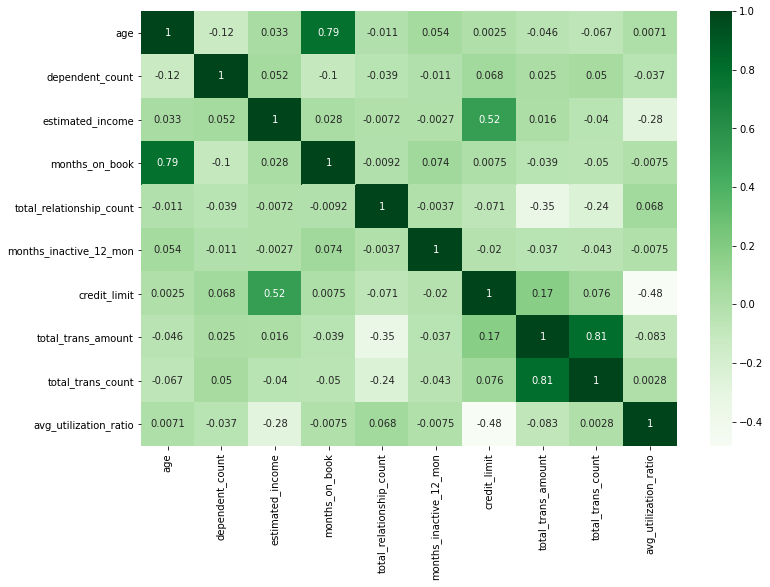

In [6]:
# Drop customer_id since we're not going to use it.
customers_clean = customers.drop('customer_id', axis=1)

correlations = customers_clean.corr()
plt.figure(figsize=(12,8))
sns.heatmap(correlations, annot=True, cmap='Greens')

The following columns are correlated with each other (above or below the arbitrary cutoff points of +/- 0.3):
* `age` and `months_on_book` (positive);
* `credit_limit` and `estimated_income` (positive);
* `credit_limit` and `avg_utilization_ratio` (negative); 
* `total_trans_amount` and `total_trans_count`  (positive); and
* `total_relationship_count` and `total_trans_amount` (negative).

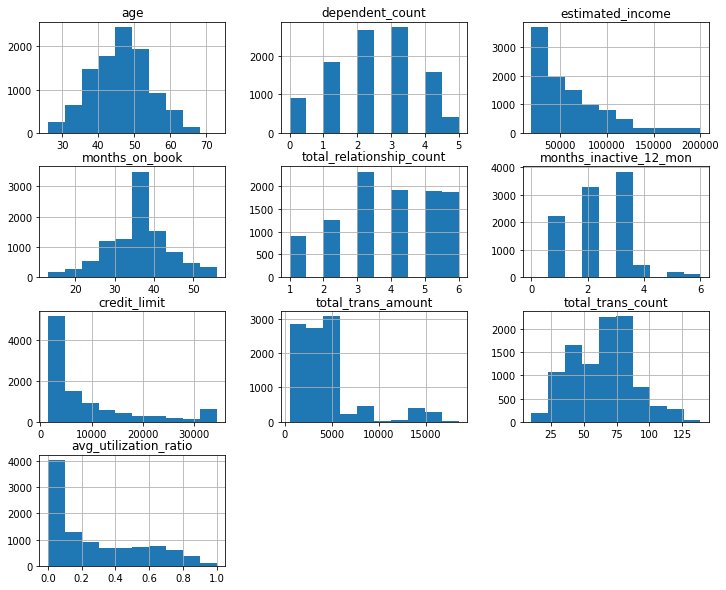

In [7]:
import warnings
warnings.filterwarnings('ignore')

# Plot the distribution of each numeric column
fig, ax = plt.subplots(figsize=(12,10))

customers_clean.hist(ax=ax)
plt.show()

The distribution of `age` and `credit_limit` appears close to being normal, while the rest look skewed.

In [8]:
# Let's look at the categorical variables
categorical_cols = ['gender', 'education_level', 'marital_status']

for column in categorical_cols:
    print(customers[column].value_counts(), end='\n\n')

F    5358
M    4769
Name: gender, dtype: int64

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64



## 2. Feature Engineering

There are three categorical columns: `gender`, `education_level`, and `marital_status`. We will now deal with them.

Let's first look at the gender and educational_level columns.

In [9]:
# Get the value counts for the 'gender' column
customers['gender'].value_counts()

F    5358
M    4769
Name: gender, dtype: int64

In [10]:
# Get the value counts for the 'educational_column' column
customers['education_level'].value_counts()

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

In [11]:
# Create a copy of the original 'customers' dataframe
customers_modif = customers.copy()

In [12]:
# Replace the values in the 'gender' column with 1 for 'M' and 0 for 'F'
customers_modif['gender'] = customers_modif['gender'].apply(lambda x:1 if x=='M' else 0)

In [13]:
# Check that the counts are still the same after the conversion
customers_modif['gender'].value_counts()

0    5358
1    4769
Name: gender, dtype: int64

In [14]:
# Create a replacement mapping dictionary for the education_level column
mapping = {
    'Uneducated':0,
    'High School':1,
    'College':2,
    'Graduate':3,
    'Post-Graduate':4,
    'Doctorate':5
}

customers_modif['education_level'] = customers_modif['education_level'].map(mapping)

In [15]:
# Check that the counts are still the same after the conversion
customers_modif['education_level'].value_counts().sort_index()

0    1755
1    2351
2    1192
3    3685
4     616
5     528
Name: education_level, dtype: int64

## 3. Feature Engineering - Part 2

We will now deal with the third categorical column: `marital_status`. Here, there is no level of magnitude between the categories "Single", "Married", "Divorced", and "Unknown", which means that we can't rank them objectively. We will, therefore, use one-hot-encoding to create dummy variables from this column.

In [16]:
# Perform one-hot-encoding
customers_modif = pd.get_dummies(data=customers_modif, columns=['marital_status'], drop_first=True)
customers_modif.head()

,customer_id,age,gender,dependent_count,education_level,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,marital_status_Married,marital_status_Single,marital_status_Unknown
0,768805383,45,1,3,1,69000,39,5,1,12691.0,1144,42,0.061,1,0,0
1,818770008,49,0,5,3,24000,44,6,1,8256.0,1291,33,0.105,0,1,0
2,713982108,51,1,3,3,93000,36,4,1,3418.0,1887,20,0.000,1,0,0
3,769911858,40,0,4,1,37000,34,3,4,3313.0,1171,20,0.760,0,0,1
4,709106358,40,1,3,0,65000,21,5,1,4716.0,816,28,0.000,1,0,0


## 4. Scaling the Data

We now need to transform the data so they're all on the same scale.

In [17]:
# We need to drop the customer_id column since we're not going to use it
customers_modif = customers_modif.drop('customer_id', axis=1)

In [18]:
# Instantiate a StandardScaler() class and fit the new dataframe
scaler = StandardScaler()
scaler.fit(customers_modif)

customers_scaled = scaler.transform(customers_modif)
print(customers_scaled[:5])

[[-0.16540558  1.05995565  0.50336813 -0.75221102  0.1758098   0.38462088
   0.76394261 -1.32713603  0.4466219  -0.95970657 -0.97389518 -0.77588223
   1.07733799 -0.79850685 -0.28260887]
 [ 0.33357038 -0.9434357   2.04319867  0.66278684 -0.96716585  1.01071482
   1.40730617 -1.32713603 -0.04136665 -0.91643261 -1.35734038 -0.61627565
  -0.92821381  1.2523374  -0.28260887]
 [ 0.58305837  1.05995565  0.50336813  0.66278684  0.78539682  0.00896451
   0.12057905 -1.32713603 -0.5736978  -0.74098169 -1.91120566 -0.99715499
   1.07733799 -0.79850685 -0.28260887]
 [-0.78912553 -0.9434357   1.2732834  -0.75221102 -0.63697289 -0.24147306
  -0.52278451  1.64147829 -0.58525108 -0.95175829 -1.91120566  1.75968594
  -0.92821381 -0.79850685  3.53845931]
 [-0.78912553  1.05995565  0.50336813 -1.45970995  0.07421197 -1.86931731
   0.76394261 -1.32713603 -0.43087725 -1.05626345 -1.57036549 -0.99715499
   1.07733799 -0.79850685 -0.28260887]]


In [19]:
# Since the outcome of the scaler is an array, we need to transform it back into a dataframe
X = pd.DataFrame(customers_scaled)

## 5. Choosing K

The next step is to work out the best number of clusters to use in the segmentation according to the inertia metric.

We need to create a few models and compute the inertia from each. Then, we'll plot the Elbow Curve and decide on the number of clusters to use for segmenting the customers.

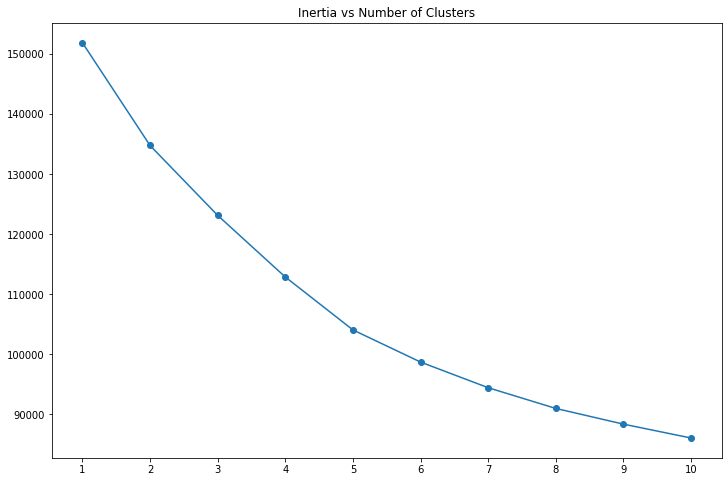

In [20]:
# Create an empty list to store the inertia from every model
inertias = []

for k in range(1, 11):
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(X)
    inertias.append(model.inertia_)
    
# Use the inertias list to plot the elbow curve
plt.figure(figsize=(12, 8))
plt.plot(range(1, 11), inertias, marker='o')
plt.xticks(ticks=range(1, 11), labels=range(1, 11))
plt.title('Inertia vs Number of Clusters')
plt.show()

From the graph above, the rate in the decrease of inertia starts to slow down when the number of clusters is 5. So, we will now use 5 clusters.

In [21]:
model = KMeans(n_clusters=5)
clusters = model.fit_predict(X)
print(clusters)

[2 1 2 ... 4 0 4]


## 6. Analysing Results

To better understand what each cluster represents, we need to see how the variables used in the clusterisation differ from cluster to cluster.

In [22]:
# Create a new column in the original customers dataframe containing the cluster assigned to each customer by the algorithm
customers['CLUSTER'] = clusters + 1
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,CLUSTER
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,3
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,2
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,M,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,4
10123,710638233,41,M,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,2
10124,716506083,44,F,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,5
10125,717406983,30,M,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,1


In [23]:
customers['CLUSTER'].value_counts()

5    3448
2    2971
3    2006
4     963
1     739
Name: CLUSTER, dtype: int64

Cluster 1 is the largest cluster and 5 is the smallest cluster.

We'll now analyse the numerical variables and see how they behave in each cluster.

To analyse the numerical variables and see how they behave in each cluster, we will use the `groupby` method to group each column in the `customers` dataframe by the `CLUSTER` column, and take the average.

We will then plot a bar chart for each column where each bar is the average of the column for a cluster.

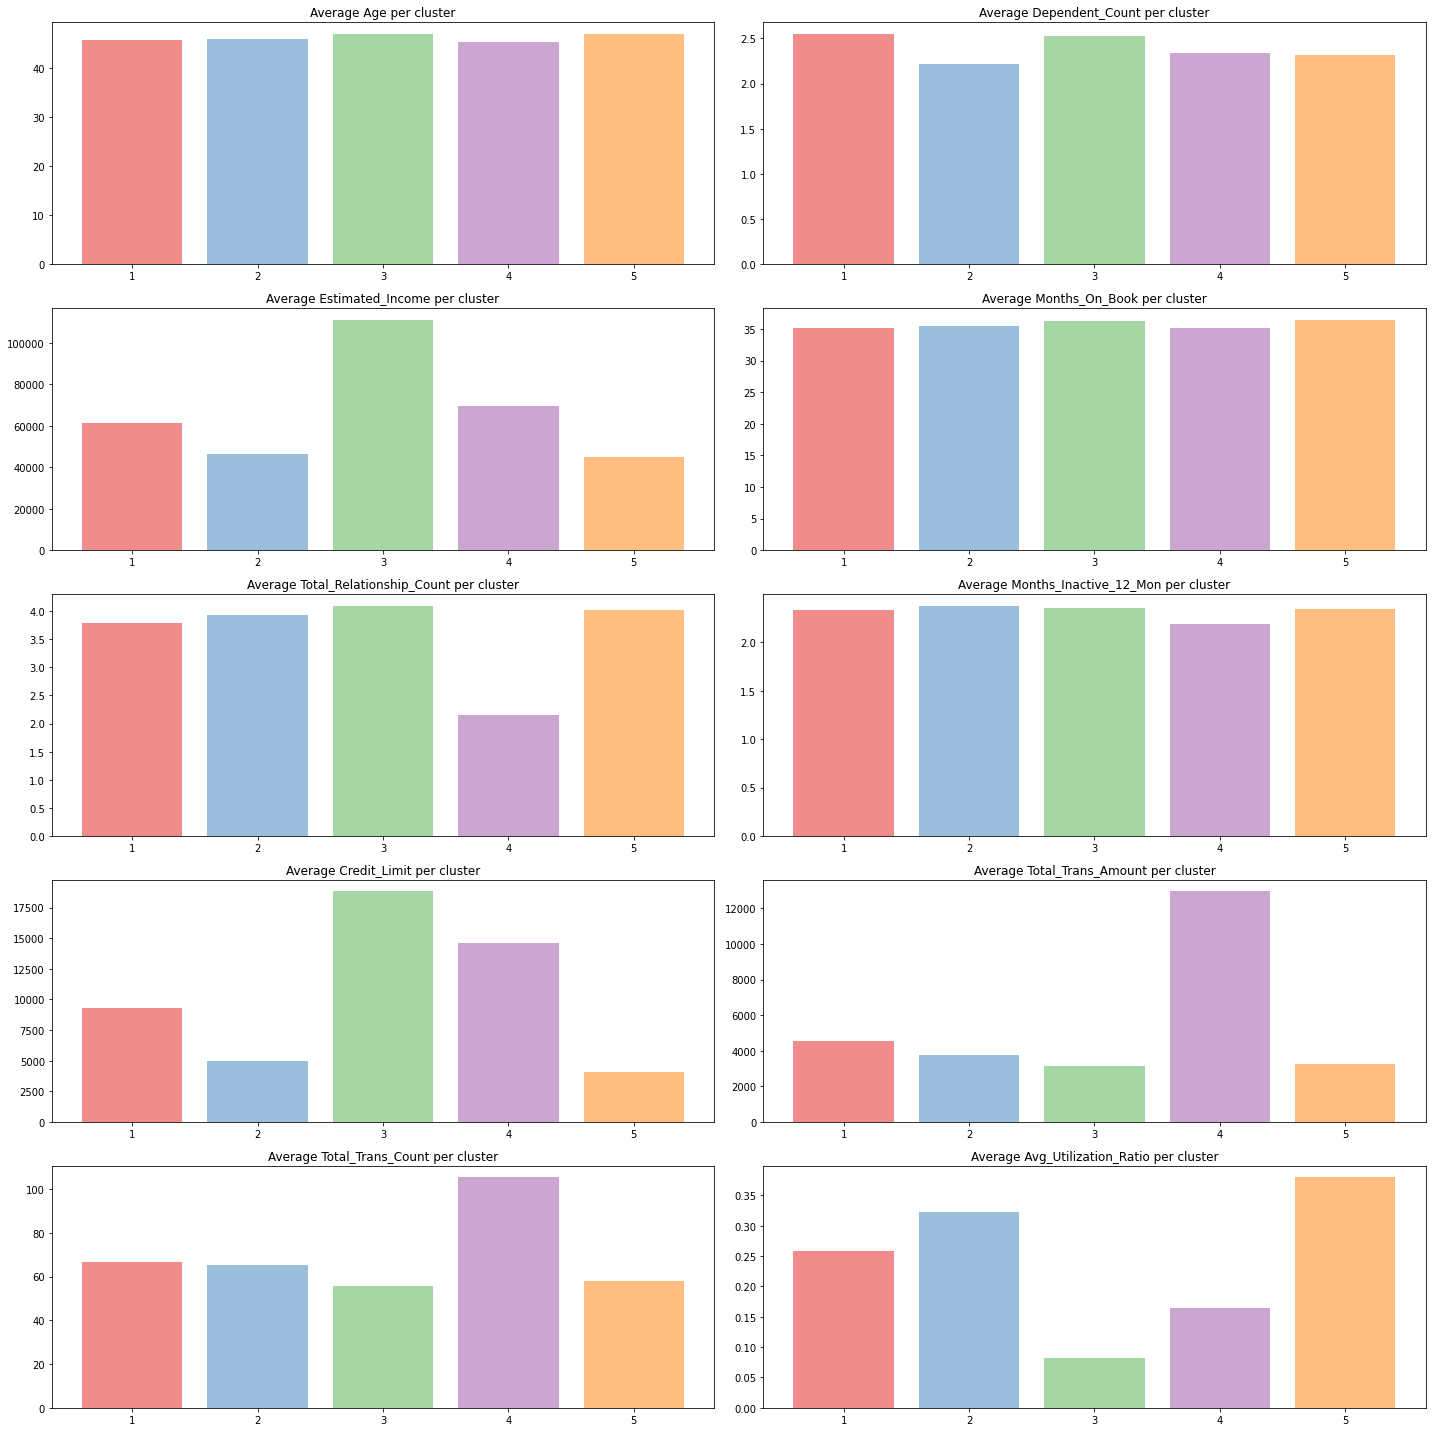

In [24]:
# Get the numeric columns
numeric_columns = customers.select_dtypes(include=np.number).drop(['customer_id', 'CLUSTER'], axis=1).columns

fig = plt.figure(figsize=(20, 20))
for i, column in enumerate(numeric_columns):
    df_plot = customers.groupby('CLUSTER')[column].mean()
    ax = fig.add_subplot(5, 2, i+1)
    ax.bar(df_plot.index, df_plot, color=sns.color_palette('Set1'),  alpha=0.5)
    ax.set_title(f'Average {column.title()} per cluster')

plt.tight_layout()
plt.show()

Some points of note from the graphs above:
* Cluster 2 has the highest average estimated income and the highest average credit limit;
* Cluster 1 has the highest average total transaction count and the highest average total transaction amount;
* Cluster 2 has the lowest average utilization ratio and the lowest average total transaction amount.

We will now create a scatter plot for each cluster of pairs of variables with a high correlation.

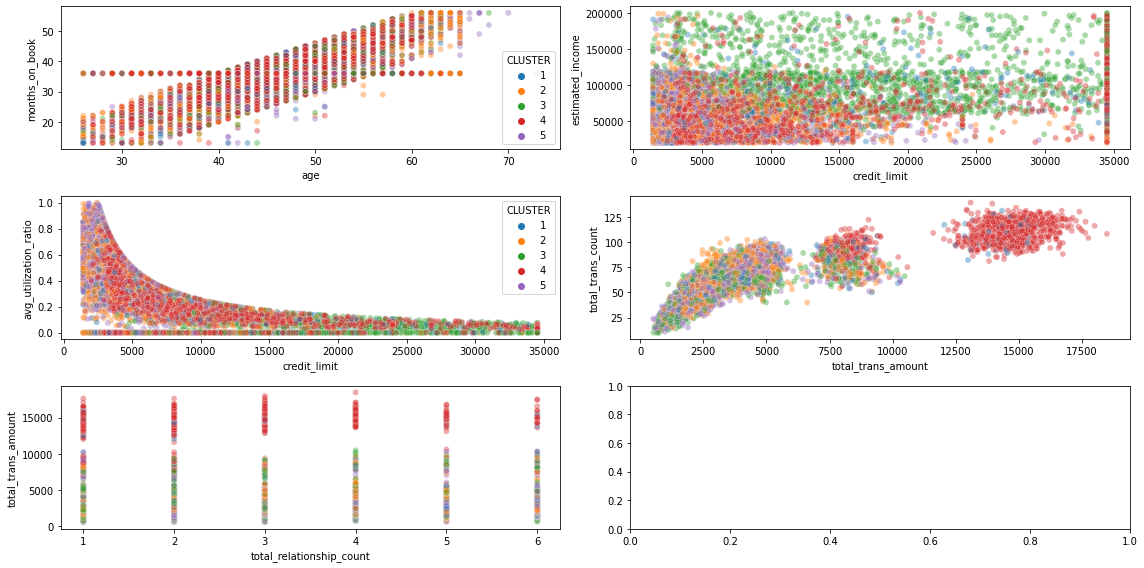

In [25]:
# Highly correlated variaables:
# age and months_on_book (positive);
# credit_limit and estimated_income (positive);
# credit_limit and avg_utilization_ratio (negative);
# total_trans_amount and total_trans_count (positive); and
# total_relationship_count and total_trans_amount (negative).

fig, axs = plt.subplots(3, 2, figsize=(16, 8))
sns.scatterplot(
     x="age",
     y="months_on_book",
     hue="CLUSTER",
     data=customers,
     palette="tab10",
     alpha=0.4,
     ax=axs[0][0],
 )
 
sns.scatterplot(
     x="credit_limit",
     y="estimated_income",
     hue="CLUSTER",
     data=customers,
     palette="tab10",
     alpha=0.4,
     ax=axs[0][1],
     legend=False,
 )
 
sns.scatterplot(
     x="credit_limit",
     y="avg_utilization_ratio",
     hue="CLUSTER",
     data=customers,
     palette="tab10",
     alpha=0.4,
     ax=axs[1][0],
 )
    
sns.scatterplot(
     x="total_trans_amount",
     y="total_trans_count",
     hue="CLUSTER",
     data=customers,
     palette="tab10",
     alpha=0.4,
     ax=axs[1][1],
    legend=False
 )

sns.scatterplot(
     x="total_relationship_count",
     y="total_trans_amount",
     hue="CLUSTER",
     data=customers,
     palette="tab10",
     alpha=0.4,
     ax=axs[2][0],
     legend=False,
 )
 
plt.tight_layout()
plt.show()

We will now focus on the categorical columns and calculate the percentual distribution of each variable per cluster.

In [31]:
categorical_cols = customers.select_dtypes(include=['object'])

#fig = plt.figure(figsize=(18, 6))
for i, column in enumerate(categorical_cols):
    plot_df = pd.crosstab(index=customers['CLUSTER'], columns=customers[column], values=customers[column], aggfunc='size', normalize='index')
    ax = fig.add_subplot(1, 3, i+1)
#    plot_df.plot.bar(stacked=True, ax=ax, alpha=0.5)
 #   ax.set_title(f'Percentage {column.title()} per Cluster', alpha=0.5)

plt.tight_layout()
plt.show()



KeyError: '__dummy__'

Some points of interest from the graphs above:
* Cluster 4 contains contains mostly males;
* The distribution of educational levels is similar between clusters;
* Cluster 2 contains mostly married people, the marital status of all people in Cluster 3 is unknown, and Cluster 5 contains predominantly single people.

## Conclusion

### Cluster 1
**Characteristics:** Mostly men, roughly half married and half single, low total relationship count, high credit limit, high overall amount of money spent on the card, high card usage, and low daily average utilization ratio.

**Business suggestion(s):** Should be encouraged to maintain or increase usage given high total transaction amount.

### Cluster 2
**Characteristics:** Mostly women, mostly married, low estimated income, low credit limit, low overall amount of money spent on the card, high daily average utilization ratio.

**Business suggestion(s):** Possibly increase credit limit and encouraged to increase usage.

### Cluster 3
**Characteristics:** Equal amount of men and women, marital status unknown for all, low estimated income, low credit limit, low overall amount of money spent on the card.

**Business suggestion(s):** Similar characteristics to Cluster 2, and so maybe use the same strategies.

### Cluster 4
**Characteristics:** Almost all men, around half are married, high credit limit, low overall amount of money spent on the card, low overall number of times card used, low average utilization ratio.

**Business suggestion(s):** Encourage to use card more, given high credit limit and low card usage. Characteristics are similar to Cluster 1, and so maybe use the same strategies.

### Cluster 5
**Characteristics:** Mostly women, nearly all are single, low income, low credit limit, low overall amount of money spent on the card, high daily average use.

**Business suggestion(s):** Similar to Cluster 2, and could use the same strategies.